In [1]:
import utils
import random
import gym
import math
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from itertools import count
from PIL import Image
from tqdm import tqdm_notebook

import fastai
from fastai.layers import AdaptiveConcatPool2d, conv_layer, Flatten
from fastai.text.models import MultiHeadAttention, PositionalEncoding

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython import display

In [2]:
# pick your environment

#### you have to hardcode the win condidion of the environment
### in the training loop, the current win condition is for
### cartpole-v0: average of > 195 reward over 100 consecutive episodes
### the curent notebook solves cartpole-v0

env = gym.make('CartPole-v0').unwrapped
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

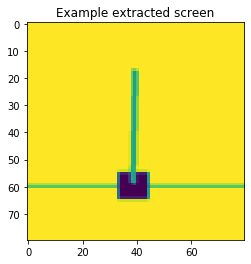

In [3]:
env.reset()
plt.figure()
plt.imshow(utils.get_screen(env).cpu().squeeze(0).permute(1, 2, 0).squeeze(-1).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [4]:
### HELPER FUNCTIONS ###

### plotting durations of episodes###
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title(str(steps_done))
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 10:
        means = durations_t.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(9), means))
        plt.plot(means.numpy())
        
    display.display(plt.gcf())
    
    
### action selector for the RL agent ###

# epsilon-greedy exploration:
# pick random action with probability epsilon,
# pick best action with probabilty 1 - epsilon
def select_action(state, eps):
    global steps_done
    sample = sample = random.uniform(0,1)
    
    steps_done += 1
    if (sample > eps) and (steps_done > WARMUP):
        with torch.no_grad():
            # using the policy network to get the best available 
            # action
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


### Deep Q Network archi ###

class DQN(nn.Module):
    """DQN - Playing Atari with Reinforcement learning https://arxiv.org/abs/1312.5602"""
    def __init__(self, cnn, cnn_out_sz, n_actions, act_fn = nn.ReLU()) :
        super().__init__()
        self.cnn = cnn
        self.act_fn = act_fn
        self.lin = nn.Linear(cnn_out_sz, 256)
        self.value = nn.Linear(256, n_actions)
        
    def forward(self, frames):
        x = self.cnn(frames)
        x = self.act_fn(x) # (bs, n_frames * frame_emb_sz)
        
        x = self.lin(x)
        x = self.act_fn(x) # (bs, 512)
        
        # (bs, n_actions)
        return self.value(x) # (bs, n_actions)
    
    
class DuelingDQN(nn.Module) :
    """Dueling QDN Architecture https://arxiv.org/pdf/1511.06581.pdf"""
    def __init__(self, cnn, cnn_out_sz, n_actions, act_fn = nn.ReLU(inplace=True)) :
        super().__init__()
        self.cnn = cnn
        self.act_fn = act_fn
        
        self.fc_val = nn.Linear(cnn_out_sz, 256)
        self.fc_adv = nn.Linear(cnn_out_sz, 256)
        self.value = nn.Linear(256, 1)
        self.advantage = nn.Linear(256, n_actions)
    
    def forward(self, frames) :
        x = self.act_fn(self.cnn(frames)) # (bs, n_frames * frame_emb_sz)
        
        val = self.act_fn(self.fc_val(x))
        val = self.value(val)
        
        adv = self.act_fn(self.fc_adv(x))
        adv = self.advantage(adv)
        advAverage = torch.mean(adv, dim=1, keepdim=True)
        
        return val + adv - advAverage
    
    
### Training DQN ###

# Getting some previously stored batches of (state, action, next_state, reward)
# and training the DQN on them for 1 step.

# We're using Double Q-learning (https://arxiv.org/pdf/1509.06461.pdf)
# therefore policy and target networks are used.

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = utils.Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    #loss = loss_func(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [5]:
# CNN layers
layers = [conv_layer(4, 16, stride = 2, ks = 4, norm_type = None), 
          conv_layer(16, 32, stride = 2, ks = 4, norm_type = None), 
          conv_layer(32, 64, stride = 2, ks = 4, norm_type = None),
          conv_layer(64, 128, stride = 2, ks = 4, norm_type = None),
          AdaptiveConcatPool2d(1), 
          Flatten()]

In [6]:
# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = utils.get_screen(env)
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DuelingDQN(nn.Sequential(*layers), 256, n_actions).to(device)
target_net = DuelingDQN(nn.Sequential(*layers), 256, n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

#optimizer = optim.Adam(policy_net.parameters(), lr = 0.0000625)
optimizer = optim.RMSprop(policy_net.parameters(), lr = 0.0001)
# to store (state, action, next_state, reward) experiences
memory = utils.ReplayMemory(50000)

In [ ]:
# probability of picking actions at random
EPS_START = 1.0
EPS_END = 0.03

# episode frequency at wich target network is updated
TARGET_UPDATE = 60

# number of steps before nn is trained
WARMUP = 126

# total number of episodes
num_episodes = 2000

eps = EPS_START
BATCH_SIZE = 128
GAMMA = 0.99
steps_done = 0
rewards = [0]
episode_durations = []
for i_episode in tqdm_notebook(range(num_episodes)):
    # Initialize the environment and state
    env.reset()
    
    acc_reward = 0
    
    current_screen = utils.get_screen(env)
    screen_history = [current_screen]*4
    state = torch.cat(screen_history, 1)
    
    for t in count():
        # Select and perform an action
        action = select_action(state, eps)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        # Observe new screen
        current_screen = utils.get_screen(env)
        screen_history = [current_screen] + screen_history[:-1]
        if not done:
            next_state = torch.cat(screen_history, 1)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        env.render()
        acc_reward += reward

        # Perform one step of the optimization on the policy network
        if t % 4 == 0: 
            optimize_model()
            
        if done:
            rewards.append(acc_reward.cpu().numpy()[0])
            episode_durations.append(t + 1)
            break
            
    # CARTPOLE-V0 WIN CONDITION
    if np.mean(rewards[-100:]) >= 195:
        print("VICTORY")
        break
    
    # reducing the probability of picking a random action
    if steps_done > WARMUP:
        eps = max(EPS_END, eps * 0.95)
        
    # resetting the probability of picking a random action    
    if i_episode == (num_episodes // 2):
        print("Resetting epsilon")
        eps = EPS_START / 3
        EPS_END /= 3
    
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        print("Updating weights")
        print(f"Average reward since last update: {round(np.mean(rewards),3)}")
        print(f"Percentage of random actions: {round(eps,3)}")
        rewards = [0]
        
plot_durations()
print('Complete')
env.render()
env.close()